In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cleaned data saved as /content/Volkswagen_Cleaned_Stock_Data.csv


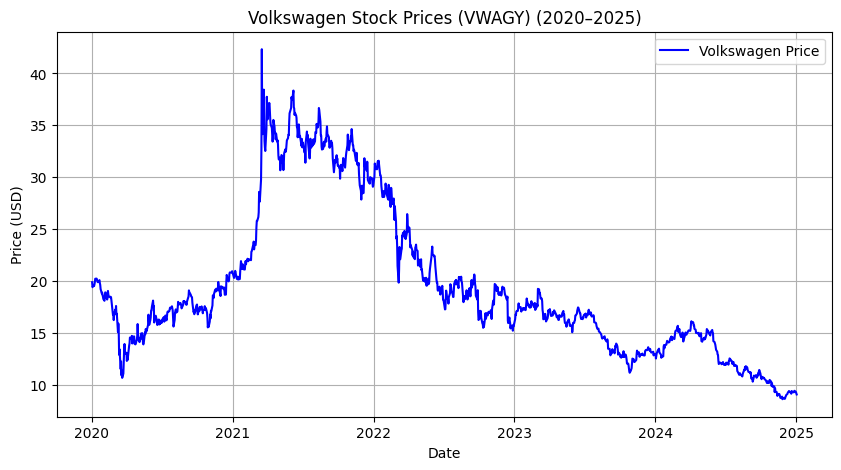

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw CSV
file_path = "/content/Volkswagen 1_10 ADR Stock Price History.csv"
df = pd.read_csv(file_path)

# Convert 'Date' and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")

# Clean numeric columns
columns_to_convert = ['Price', 'Open', 'High', 'Low']
for col in columns_to_convert:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Clean 'Vol.'
def convert_volume(value):
    value = str(value).replace(',', '')
    if 'M' in value:
        return float(value.replace('M', '')) * 1_000_000
    elif 'K' in value:
        return float(value.replace('K', '')) * 1_000
    else:
        return float(value)

df['Vol.'] = df['Vol.'].apply(convert_volume)

# Clean 'Change %'
df['Change %'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

# Fill missing with median
df = df.fillna(df.median(numeric_only=True))

# Save cleaned data
cleaned_file_path = "/content/Volkswagen_Cleaned_Stock_Data.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved as {cleaned_file_path}")

# Plot price over time
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Price"], label="Volkswagen Price", color="blue")
plt.title("Volkswagen Stock Prices (VWAGY) (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

March–July Average Stock Price by Year:
Year
2021    33.367776
2022    21.265169
2023    16.737743
2020    15.233281
2024    13.941773
2025          NaN
dtype: float64


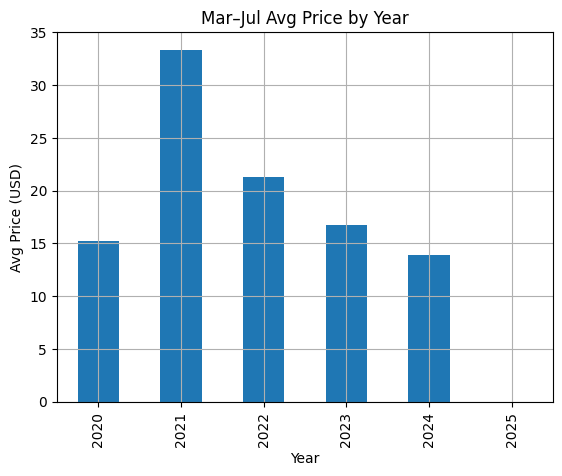

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract year and month
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group by Year and Month and calculate average price
monthly_avg = df.groupby(['Year', 'Month'])['Price'].mean().unstack(level=0)

# Plot to compare March–July average across years
spring_summer = monthly_avg.loc[3:7]  # Mar to Jul
avg_peak_per_year = spring_summer.mean()

print("March–July Average Stock Price by Year:")
print(avg_peak_per_year.sort_values(ascending=False))

# Plot as bar chart
avg_peak_per_year.plot(kind='bar', title='Mar–Jul Avg Price by Year', ylabel='Avg Price (USD)', xlabel='Year')
plt.grid()
plt.show()


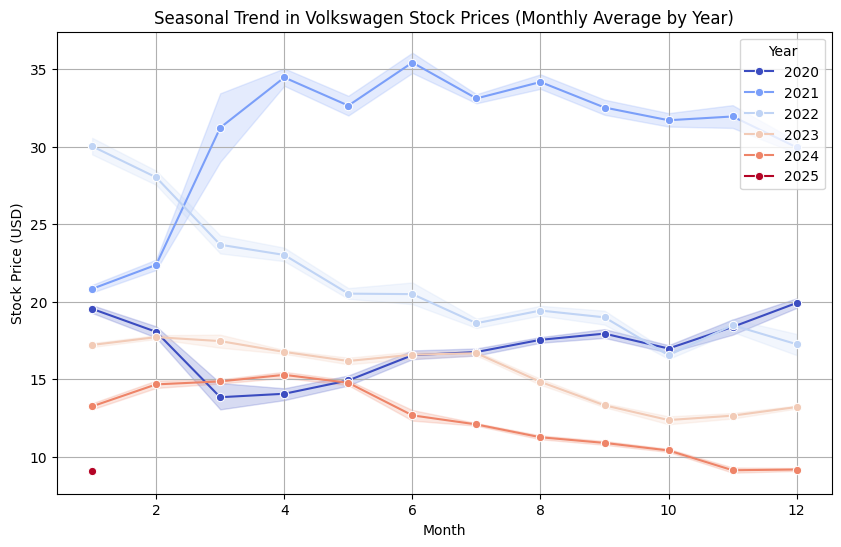

In [ ]:
import seaborn as sns

# Re-add if lost during reloading
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Year'] = df.index.year
df['Month'] = df.index.month

# Plot seasonality by month and year
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Price', hue='Year', data=df, marker='o', palette='coolwarm')
plt.title('Seasonal Trend in Volkswagen Stock Prices (Monthly Average by Year)')
plt.xlabel('Month')
plt.ylabel('Stock Price (USD)')
plt.grid()
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Re-load or access cleaned df with datetime index
df = df.sort_index()
series = df["Price"]

# Split into train/test
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluation
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)

print(f"ARIMA RMSE: {rmse:.4f}")
print(f"ARIMA MAPE: {mape:.4f}")

ARIMA RMSE: 2.2538
ARIMA MAPE: 0.1761


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

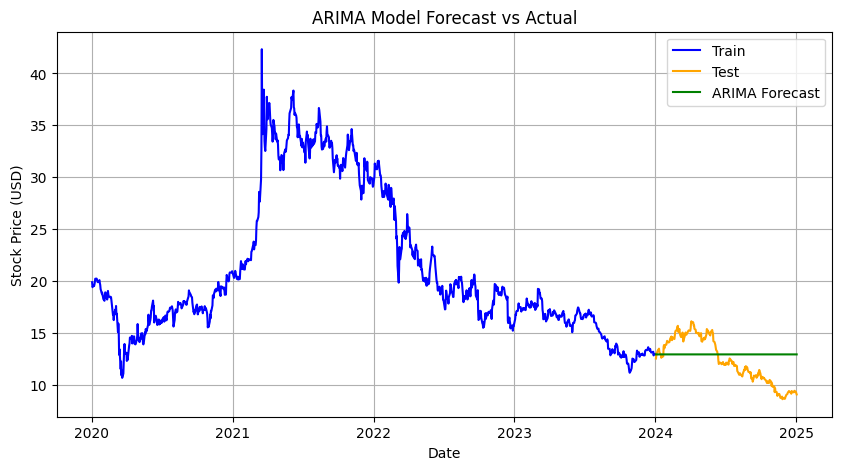

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.title("ARIMA Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import warnings
import itertools
from statsmodels.tsa.arima.model import ARIMA

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_score, best_cfg = float("inf"), None

for param in pdq:
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = ARIMA(train, order=param)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, forecast))
            if rmse < best_score:
                best_score, best_cfg = rmse, param
    except:
        continue

print(f"Best ARIMA order: {best_cfg} with RMSE = {best_score:.4f}")

Best ARIMA order: (3, 2, 1) with RMSE = 1.7198


In [ ]:
# Refit ARIMA with best (p,d,q)
from statsmodels.tsa.arima.model import ARIMA

final_model = ARIMA(train, order=(3, 2, 1))
final_model_fit = final_model.fit()

# Forecast
final_forecast = final_model_fit.forecast(steps=len(test))

# Evaluation
final_rmse = np.sqrt(mean_squared_error(test, final_forecast))
final_mape = mean_absolute_percentage_error(test, final_forecast)

print(f"Final ARIMA (3,2,1) RMSE: {final_rmse:.4f}")
print(f"Final ARIMA (3,2,1) MAPE: {final_mape:.4f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Final ARIMA (3,2,1) RMSE: 1.7198
Final ARIMA (3,2,1) MAPE: 0.1013


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


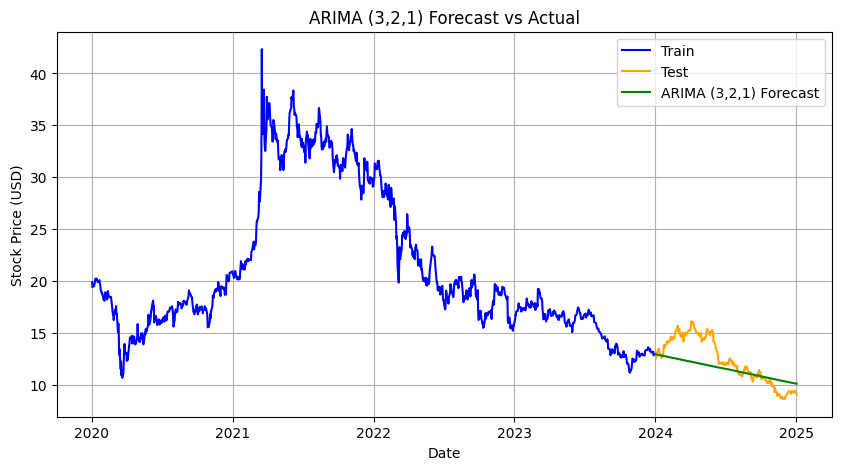

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, final_forecast, label='ARIMA (3,2,1) Forecast', color='green')
plt.title("ARIMA (3,2,1) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install prophet cmdstanpy --upgrade --quiet

In [ ]:
# Re-import libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Load cleaned data
df = pd.read_csv("/content/Volkswagen_Cleaned_Stock_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")

# Prepare for Prophet
df_prophet = df[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})

# Split data
train_size = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:train_size]
test_prophet = df_prophet.iloc[train_size:]

In [ ]:
m = Prophet(yearly_seasonality=True, daily_seasonality=False)
m.fit(train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwa2busj6/lgc9uau3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwa2busj6/xq6u2uv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14865', 'data', 'file=/tmp/tmpwa2busj6/lgc9uau3.json', 'init=/tmp/tmpwa2busj6/xq6u2uv9.json', 'output', 'file=/tmp/tmp1es767io/prophet_modelb2iqkjic/prophet_model-20250512223409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:34:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:34:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Make future dataframe
future = m.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast = m.predict(future)

# Align predictions to test period
forecast_values = forecast[['ds', 'yhat']].iloc[-len(test_prophet):]
forecast_values.set_index('ds', inplace=True)

# Evaluation
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], forecast_values['yhat']))
mape_prophet = mean_absolute_percentage_error(test_prophet['y'], forecast_values['yhat'])

print(f"Prophet RMSE: {rmse_prophet:.4f}")
print(f"Prophet MAPE: {mape_prophet:.4f}")

Prophet RMSE: 2.2540
Prophet MAPE: 0.1334


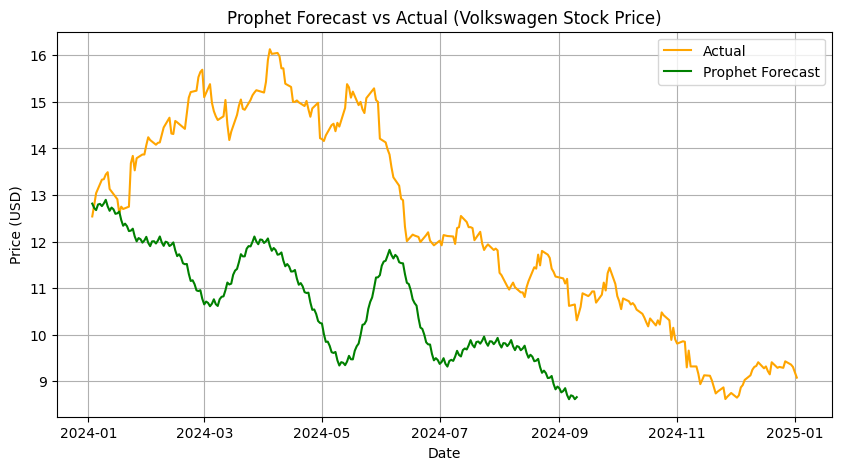

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='orange')
plt.plot(forecast_values.index, forecast_values['yhat'], label='Prophet Forecast', color='green')
plt.title('Prophet Forecast vs Actual (Volkswagen Stock Price)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install xgboost --quiet

In [ ]:
import pandas as pd

# Reload cleaned dataset
df = pd.read_csv("/content/Volkswagen_Cleaned_Stock_Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')

# Create lag features
df['lag1'] = df['Price'].shift(1)
df['lag2'] = df['Price'].shift(2)
df.dropna(inplace=True)

In [ ]:
# Define features and target
X = df[['lag1', 'lag2']]
y = df['Price']

# 80/20 split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

model = XGBRegressor()
model.fit(X_train, y_train)

# Predict
y_pred_xgb = model.predict(X_test)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost MAPE: {mape_xgb:.4f}")

XGBoost RMSE: 1.4951
XGBoost MAPE: 0.0999


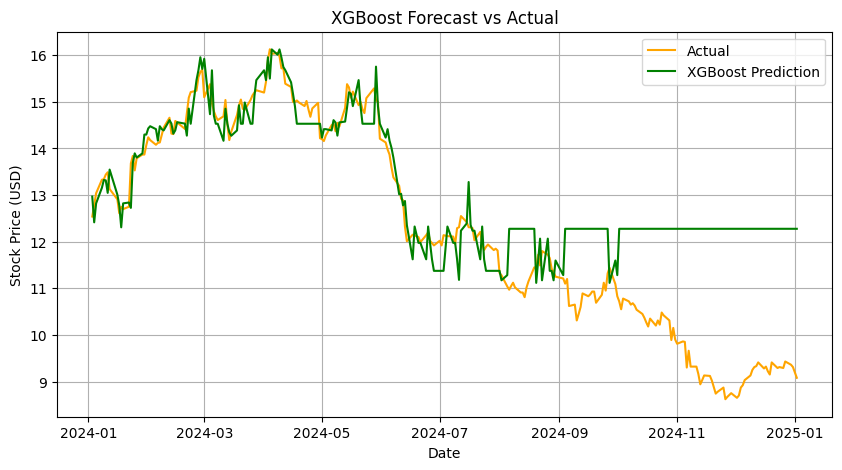

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Actual', color='orange')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Prediction', color='green')
plt.title('XGBoost Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

In [ ]:
# Use only the 'Price' column
prices = df[['Price']].values

# Normalize prices
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

In [ ]:
def create_sequences(data, seq_length=30):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 30
X_all, y_all = create_sequences(scaled_prices, sequence_length)

In [ ]:
train_size = int(len(X_all) * 0.8)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (981, 30, 1)
Testing Data Shape: (246, 30, 1)


In [ ]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0394 - val_loss: 0.0025
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0052 - val_loss: 3.2175e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0034 - val_loss: 2.7070e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0052 - val_loss: 4.4324e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0027 - val_loss: 2.6856e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 2.8785e-04
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0030 - val_loss: 2.0596e-04
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024 - val_loss: 2.0896e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 4.6367e-04
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023 - val_loss: 4.6972e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0022 - val_loss: 1.8462e-04
Epoch 12/20
31/31 ━━━━

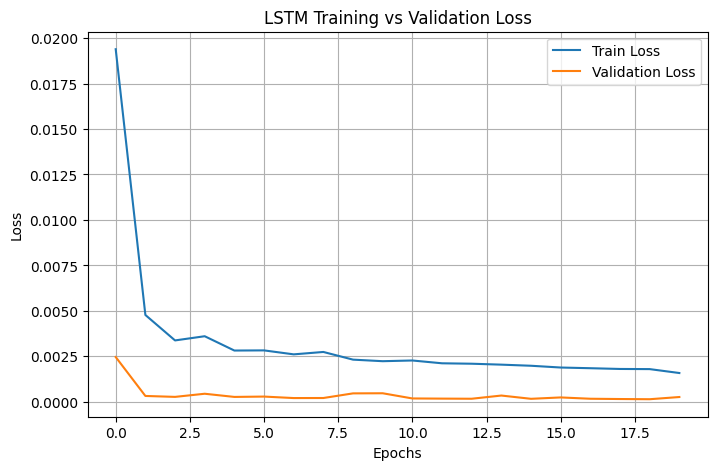

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Make predictions
predicted_scaled = model.predict(X_test)

# Rescale predictions and actuals
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test)

# Flatten for metric calculation
predicted = predicted.flatten()
actual = actual.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse_lstm = np.sqrt(mean_squared_error(actual, predicted))
mape_lstm = mean_absolute_percentage_error(actual, predicted)

print(f"LSTM RMSE: {rmse_lstm:.4f}")
print(f"LSTM MAPE: {mape_lstm:.4f}")

LSTM RMSE: 0.5467
LSTM MAPE: 0.0364


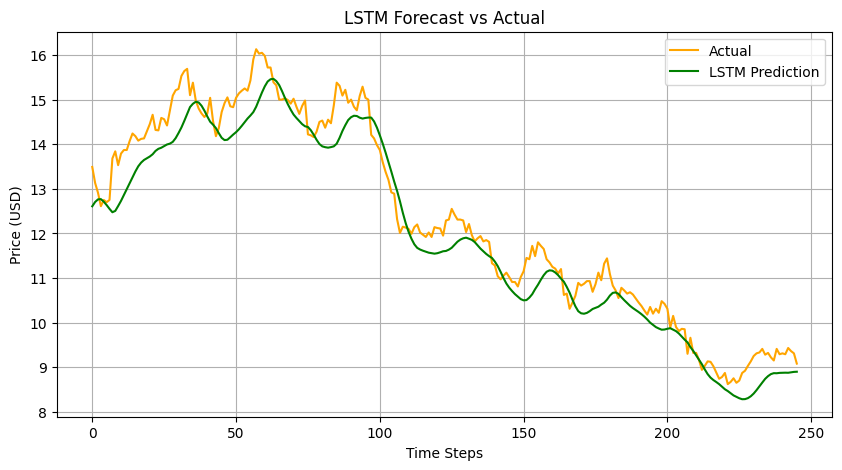

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual', color='orange')
plt.plot(predicted, label='LSTM Prediction', color='green')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute residuals: actual - predicted
lstm_residuals = actual - predicted

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(lstm_residuals, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# Forecast residuals
residual_forecast = sarima_result.forecast(steps=len(predicted))

In [ ]:
# Combine LSTM prediction with SARIMA residual correction
hybrid_forecast = predicted + residual_forecast

In [ ]:
rmse_hybrid = np.sqrt(mean_squared_error(actual, hybrid_forecast))
mape_hybrid = mean_absolute_percentage_error(actual, hybrid_forecast)

print(f"Hybrid (LSTM + SARIMA) RMSE: {rmse_hybrid:.4f}")
print(f"Hybrid (LSTM + SARIMA) MAPE: {mape_hybrid:.4f}")

Hybrid (LSTM + SARIMA) RMSE: 0.5388
Hybrid (LSTM + SARIMA) MAPE: 0.0360


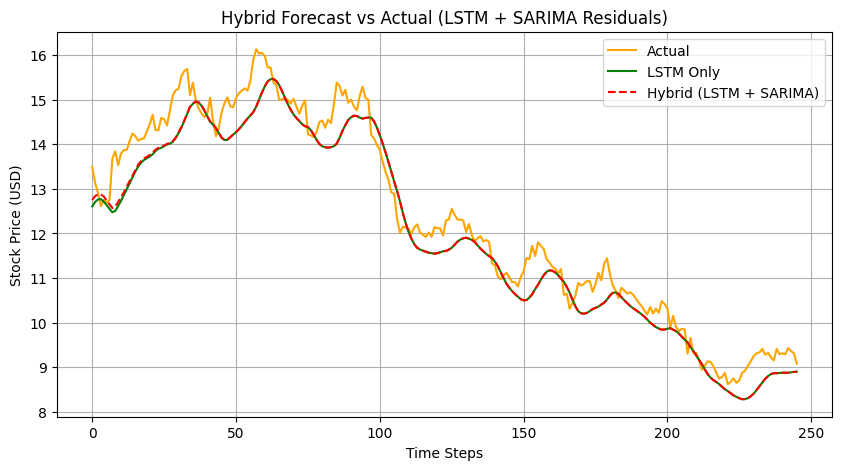

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual', color='orange')
plt.plot(predicted, label='LSTM Only', color='green')
plt.plot(hybrid_forecast, label='Hybrid (LSTM + SARIMA)', color='red', linestyle='dashed')
plt.title("Hybrid Forecast vs Actual (LSTM + SARIMA Residuals)")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(lstm_residuals)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -4.8561805599883705
p-value: 4.2411302712610876e-05


In [ ]:
# Try a slightly different SARIMA config
sarima_model = SARIMAX(lstm_residuals, order=(2, 0, 2), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# Forecast & combine
residual_forecast = sarima_result.forecast(steps=len(predicted))
hybrid_forecast = predicted + residual_forecast

# Evaluate
rmse_hybrid = np.sqrt(mean_squared_error(actual, hybrid_forecast))
mape_hybrid = mean_absolute_percentage_error(actual, hybrid_forecast)

print(f"Tuned Hybrid RMSE: {rmse_hybrid:.4f}")
print(f"Tuned Hybrid MAPE: {mape_hybrid:.4f}")

Tuned Hybrid RMSE: 0.5398
Tuned Hybrid MAPE: 0.0361
